# Modeling

By: Traci Lim

---

The objective is to **predict the flat type of flats from 2015 onwards**.

In [1]:
import time
notebookstart= time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import random
random.seed(2018)
from collections import Counter
print("Data:\n",os.listdir("data"))
import np_utils

# Models Packages
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, LogisticRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, log_loss, classification_report, accuracy_score
from sklearn import preprocessing
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier



# Gradient Boosting
import lightgbm as lgb
from sklearn.linear_model import Ridge
from sklearn.cross_validation import KFold

# Tf-Idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords 

# Viz
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import matplotlib
color = sns.color_palette()
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()
import plotly.tools as tls
%matplotlib inline
from matplotlib.pyplot import figure


pd.set_option('display.max_columns', None)  
from scipy import stats
from scipy.stats import norm, skew #for some statistics

# Thanks to https://stackoverflow.com/a/39734251
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

Data:
 ['coe-results.csv', 'coe_df.csv', 'coe_prem_df.csv', 'df_final.csv', 'df_final1.csv', 'general-information-of-schools.csv', 'G_MP14_CONS_AREA_PL.shp', 'hdb-property-information.csv', 'hdb_resale', 'latlong_df.csv', 'latlong_df.pkl', 'latlong_df_final.csv', 'MRTLRTStnPtt.dbf', 'MRTLRTStnPtt.shp', 'not_within_1km_dt_station_df.csv', 'within_1km_dt_station_df.csv']


C:\Users\longwind48\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


---

## Import Data

In [2]:
df = pd.read_csv('data/df_final.csv')#.sample(1000)

In [3]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'block', 'flat_model', 'flat_type',
       'floor_area_sqm', 'lease_commence_date', 'month', 'resale_price',
       'storey_range', 'street_name', 'town', 'full_address', 'LATITUDE',
       'LONGITUDE', 'distance_to_nearest_sch', 'distance_to_nearest_station',
       'lat_long', 'max_floor_lvl', 'year_completed', 'residential',
       'market_hawker', 'miscellaneous', 'multistorey_carpark',
       'precinct_pavilion', 'year', 'distance_to_city', 'year_month'],
      dtype='object')

In [4]:
df.tail()

,Unnamed: 0,Unnamed: 0.1,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,resale_price,storey_range,street_name,town,full_address,LATITUDE,LONGITUDE,distance_to_nearest_sch,distance_to_nearest_station,lat_long,max_floor_lvl,year_completed,residential,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion,year,distance_to_city,year_month
2944095,3100991,3100991,816,Improved,5 ROOM,122.0,1988,12,580000.0,10 TO 12,YISHUN ST 81,YISHUN,816 YISHUN ST 81,1.411771,103.833368,0.635466,0.584058,"('1.41177094390459', '103.83336826951')",12.0,1987.0,Y,N,N,N,N,2014,12.365232,2014-12
2944096,3100992,3100992,325,Maisonette,EXECUTIVE,146.0,1988,12,540000.0,10 TO 12,YISHUN CTRL,YISHUN,325 YISHUN CTRL,1.429239,103.842146,0.328180,0.725119,"('1.42923856240312', '103.842145690691')",13.0,1988.0,Y,N,Y,N,N,2014,14.409378,2014-12
2944097,3100993,3100993,618,Apartment,EXECUTIVE,164.0,1992,12,738000.0,07 TO 09,YISHUN RING RD,YISHUN,618 YISHUN RING RD,1.418735,103.835703,0.195477,0.296761,"('1.41873530060211', '103.83570328066901')",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,13.159608,2014-12
2944098,3100994,3100994,277,Maisonette,EXECUTIVE,152.0,1985,12,592000.0,07 TO 09,YISHUN ST 22,YISHUN,277 YISHUN ST 22,1.437918,103.836995,0.238737,0.924859,"('1.43791843653818', '103.836994608643')",11.0,1985.0,Y,N,Y,N,N,2014,15.283225,2014-12
2944099,3100995,3100995,277,Maisonette,EXECUTIVE,146.0,1985,12,545000.0,04 TO 06,YISHUN ST 22,YISHUN,277 YISHUN ST 22,1.437918,103.836995,0.238737,0.924859,"('1.43791843653818', '103.836994608643')",11.0,1985.0,Y,N,Y,N,N,2014,15.283225,2014-12


A peek at the data tells us we have many unwanted features. For the purpose of modeling, the importance of selection of features is not just in improving predictive power, but also to prevent data leakage.

In [471]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'block', 'flat_model', 'flat_type',
       'floor_area_sqm', 'lease_commence_date', 'month', 'resale_price',
       'storey_range', 'street_name', 'town', 'full_address', 'LATITUDE',
       'LONGITUDE', 'distance_to_nearest_sch', 'distance_to_nearest_station',
       'lat_long', 'max_floor_lvl', 'year_completed', 'residential',
       'market_hawker', 'miscellaneous', 'multistorey_carpark',
       'precinct_pavilion', 'year', 'distance_to_city'],
      dtype='object')

In [5]:
chosen_feats_list = ['flat_model', 'flat_type', 'floor_area_sqm',
                     'lease_commence_date', 'month', 'resale_price', 'storey_range',
                     'town','distance_to_nearest_sch', 'distance_to_nearest_station',
                     'distance_to_city',
                     'year']

df = df[chosen_feats_list]

In [474]:
df.head(3)

,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,resale_price,storey_range,town,distance_to_nearest_sch,distance_to_nearest_station,distance_to_city,year
0,New Generation,3 ROOM,73.0,1976,1,47200.0,04 TO 06,ANG MO KIO,0.145364,0.954205,7.585695,1990
1,New Generation,3 ROOM,67.0,1977,1,46000.0,01 TO 03,ANG MO KIO,0.181780,0.867154,7.908701,1990
2,New Generation,3 ROOM,67.0,1977,1,42000.0,07 TO 09,ANG MO KIO,0.000000,0.560273,7.925137,1990


In [6]:
missing_values_table(df)

Your selected dataframe has 12 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Before we set up our validation and test datasets, we want to finalize all features. let's get them all in first. 

In [7]:
df['flat_age'] = 2018-df['lease_commence_date']

In [8]:
del df['lease_commence_date']

In [478]:
df.head()

,flat_model,flat_type,floor_area_sqm,month,resale_price,storey_range,town,distance_to_nearest_sch,distance_to_nearest_station,distance_to_city,year,flat_age
0,New Generation,3 ROOM,73.0,1,47200.0,04 TO 06,ANG MO KIO,0.145364,0.954205,7.585695,1990,42
1,New Generation,3 ROOM,67.0,1,46000.0,01 TO 03,ANG MO KIO,0.181780,0.867154,7.908701,1990,41
2,New Generation,3 ROOM,67.0,1,42000.0,07 TO 09,ANG MO KIO,0.000000,0.560273,7.925137,1990,41
3,New Generation,3 ROOM,67.0,1,38000.0,10 TO 12,ANG MO KIO,0.203720,1.471209,7.509993,1990,41
4,New Generation,3 ROOM,67.0,1,40000.0,04 TO 06,ANG MO KIO,0.203720,1.471209,7.509993,1990,41


In [9]:
df['flat_type'].value_counts()

4 ROOM              1122040
3 ROOM               942548
5 ROOM               614748
EXECUTIVE            231580
2 ROOM                29052
1 ROOM                 2248
MULTI GENERATION       1884
Name: flat_type, dtype: int64

In [10]:
df['flat_type'] = df['flat_type'].str.replace('1 ROOM', '1RM') \
                                    .str.replace('2 ROOM', '2RM') \
                                    .str.replace('3 ROOM', '3RM') \
                                    .str.replace('4 ROOM', '4RM') \
                                    .str.replace('5 ROOM', '5RM') \
                                    .str.replace('EXECUTIVE', '6EX') \
                                    .str.replace('MULTI GENERATION', '7MG') \

We need to set up proper validation for the model to generalize well. 

---

### Setting Up Proper Validation

It is important to mimic the train-test split on our validation procedure. Since it is a time-based split, i.e. test set only contain records from 2015 to 2018, we should be careful not to use 'future' data to predict 'past' data. Thus, no k-fold cross validation was used. 

A simple holdout validation strategy was used. Validation set contains records in the year 2014 and Train set contains records in the year 2013.

In [11]:
df.dtypes

flat_model                      object
flat_type                       object
floor_area_sqm                 float64
month                            int64
resale_price                   float64
storey_range                    object
town                            object
distance_to_nearest_sch        float64
distance_to_nearest_station    float64
distance_to_city               float64
year                             int64
flat_age                         int64
dtype: object

In [12]:
train = df.loc[(df['year'] == 2014) | (df['year'] == 2013)]
test = df.loc[df['year'] >= 2015]
# To stimulate a real test set, we have to delete the response variable.

y_train = df.loc[df['year'] == 2013].flat_type
y_val = df.loc[df['year'] == 2014].flat_type
y_test = test.flat_type

In [13]:
ntrain = train.shape[0]
ntest = test.shape[0]

all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['flat_type'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (375980, 11)


In [14]:
# Split up the categorical and continous features
cont_columns = []
cat_columns = []

for i in all_data.columns:
    if train[i].dtype == 'float':
        cont_columns.append(i)
    elif train[i].dtype == 'int64':
        cont_columns.append(i)
    elif train[i].dtype == 'object':
        cat_columns.append(i)

In [15]:
cont_columns.remove('year')

In [16]:
cont_columns

['floor_area_sqm',
 'month',
 'resale_price',
 'distance_to_nearest_sch',
 'distance_to_nearest_station',
 'distance_to_city',
 'flat_age']

In [17]:
cat_columns

['flat_model', 'storey_range', 'town']

---

# Exploratory Data Analysis

Since this is a stimulated training and testing environment, we should play by the rules and not 'explore' our test set. 

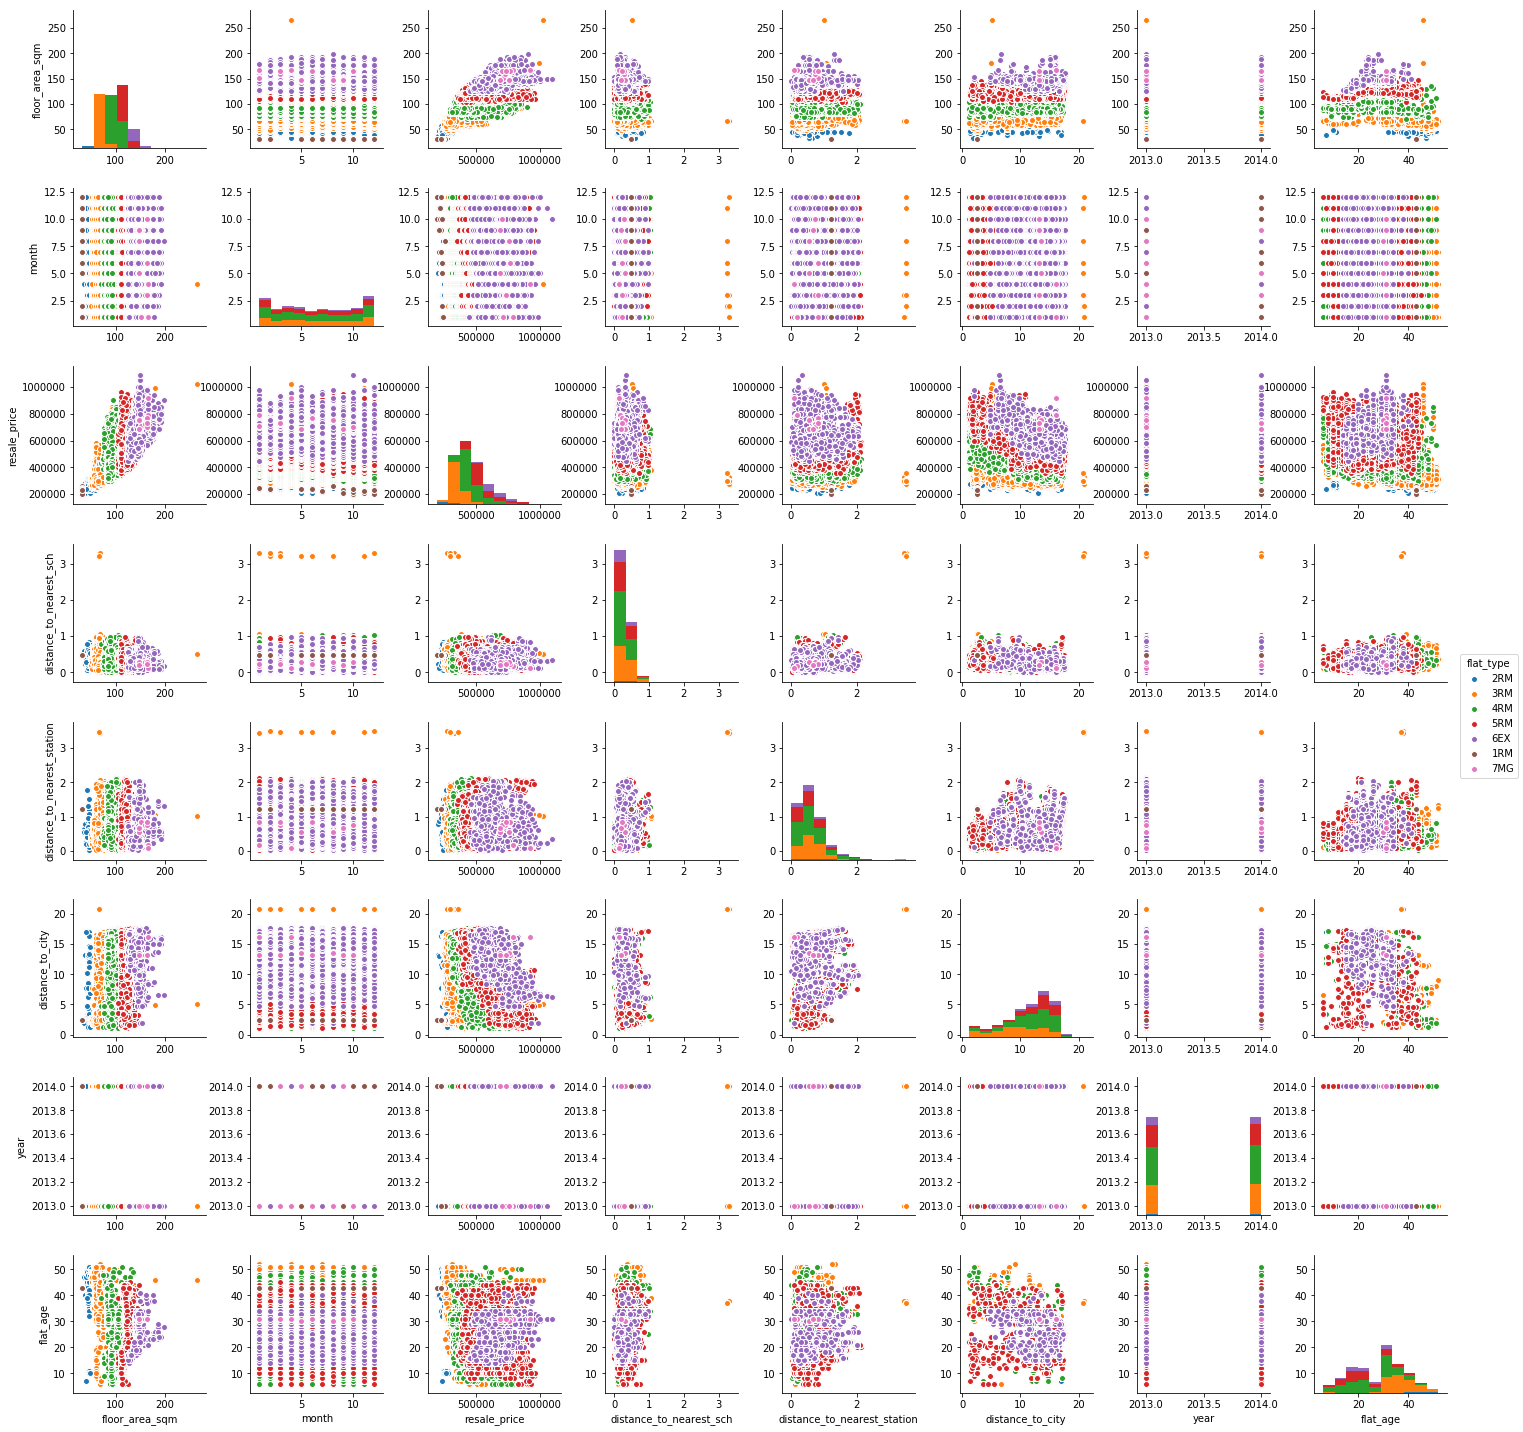

In [488]:
# sns.pairplot(train[cont_columns], vars=cont_columns, hue='flat_type' , kind = 'scatter',diag_kind='kde')
sns.pairplot(train, hue='flat_type')

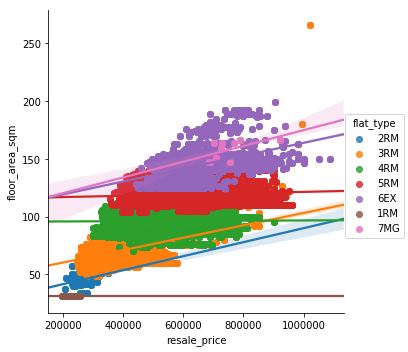

In [465]:
sns.lmplot(x="resale_price", y="floor_area_sqm", hue="flat_type", data=train)

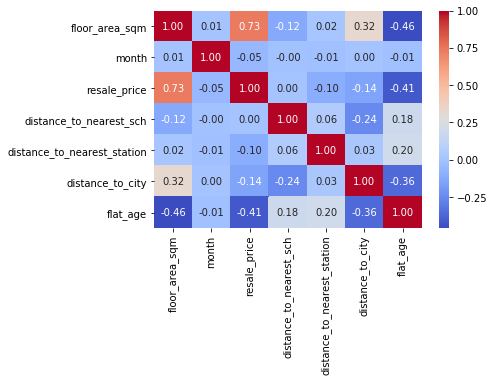

In [489]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(train[cont_columns].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

Some level of skewness may exist in some features. Let's check.

In [18]:
# Check the skew of all numerical features
skewed_feats = df[cont_columns].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
distance_to_nearest_sch,3.028310
distance_to_nearest_station,1.214302
resale_price,0.770900
floor_area_sqm,0.382141
month,-0.018680
flat_age,-0.288658
distance_to_city,-0.601735


Proceed with a boxcos transformation.

In [19]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    df[feat] = boxcox1p(df[feat], lam)

There are 7 skewed numerical features to Box Cox transform


In [20]:
# Check the skew of all numerical features
skewed_feats = df[cont_columns].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
distance_to_nearest_sch,1.158859
distance_to_nearest_station,0.597851
floor_area_sqm,-0.076439
month,-0.620840
resale_price,-0.641144
flat_age,-1.139263
distance_to_city,-1.365025


---

# Encoding

In [21]:
# Encoder:
lbl = preprocessing.LabelEncoder()
for col in cat_columns:
    all_data[col] = lbl.fit_transform(all_data[col].astype(str))

In [22]:
all_data.head()

,flat_model,floor_area_sqm,month,resale_price,storey_range,town,distance_to_nearest_sch,distance_to_nearest_station,distance_to_city,year,flat_age
0,2,44.0,1,253000.0,0,0,0.294971,0.441297,8.612158,2013,38
1,2,44.0,1,270000.0,0,0,0.119991,0.360894,7.919715,2013,40
2,2,44.0,1,283000.0,1,0,0.360817,0.256509,7.990977,2013,41
3,2,61.0,1,305000.0,2,0,0.249238,1.259833,8.284706,2013,32
4,2,60.0,1,320000.0,0,0,0.415219,1.080477,8.430452,2013,32


In [23]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [24]:
del test['year']
X_test = test.iloc[:,:]

In [25]:
X_test.shape

(251676, 10)

In [29]:
X_val.shape

(62148, 10)

In [30]:
X_train.shape

(62156, 10)

---

## Modeling

In [28]:
# Setting up train-validation split
training = train.loc[train['year'] == 2013]
validation = train.loc[train['year'] == 2014]

X_train = training.iloc[:,:]
X_val = validation.iloc[:,:]

del X_train['year']
del X_val['year']

### Decision Tree Classifier

In [31]:
dt_clf = DecisionTreeClassifier(random_state = 0).fit(X_train, y_train)

In [33]:
# The feature importances. The higher, the more important the feature. 
dt_clf.feature_importances_ 

array([6.04590661e-02, 8.92460706e-01, 8.62123621e-05, 8.74954975e-03,
       9.09637323e-05, 5.55889475e-04, 1.66202795e-03, 1.36709244e-03,
       2.66448410e-03, 3.19040077e-02])

In [32]:
y_pred = dt_clf.predict(X_val)
print(classification_report(y_val, y_pred))
print("\nAccuracy Score is: " + str(accuracy_score(y_val, y_pred)))

             precision    recall  f1-score   support

        1RM       1.00      1.00      1.00        80
        2RM       0.99      0.97      0.98       580
        3RM       0.99      1.00      1.00     18880
        4RM       1.00      1.00      1.00     24752
        5RM       1.00      1.00      1.00     13644
        6EX       1.00      1.00      1.00      4200
        7MG       0.75      1.00      0.86        12

avg / total       1.00      1.00      1.00     62148


Accuracy Score is: 0.9963313380961576


In [564]:
y_pred = dt_clf.predict(X_test)

print("\nAccuracy Score is: " + str(accuracy_score(y_test, y_pred)))


Accuracy Score is: 0.9773518333094932


---

### Gradient Boosting Trees

In [34]:
%%time
gbt = GradientBoostingClassifier(random_state = 0).fit(X_train, y_train)

Wall time: 24.3 s


In [35]:
# The feature importances. The higher, the more important the feature. 
gbt.feature_importances_ 

array([0.13239737, 0.38596349, 0.00893172, 0.06653342, 0.00328066,
       0.0274313 , 0.02795271, 0.04755528, 0.08396841, 0.13169994])

In [36]:
y_pred = gbt.predict(X_val)
print(classification_report(y_val, y_pred))
print("\nAccuracy Score is: " + str(accuracy_score(y_val, y_pred)))

             precision    recall  f1-score   support

        1RM       1.00      1.00      1.00        80
        2RM       0.99      0.97      0.98       580
        3RM       1.00      1.00      1.00     18880
        4RM       1.00      1.00      1.00     24752
        5RM       1.00      0.99      0.99     13644
        6EX       1.00      1.00      1.00      4200
        7MG       0.06      1.00      0.11        12

avg / total       1.00      0.99      1.00     62148


Accuracy Score is: 0.9941430134517603


In [37]:
y_pred = gbt.predict(X_test)
print(classification_report(y_test, y_pred))
print("\nAccuracy Score is: " + str(accuracy_score(y_test, y_pred)))

             precision    recall  f1-score   support

        1RM       1.00      1.00      1.00        96
        2RM       0.51      0.98      0.67      2308
        3RM       0.99      0.96      0.98     62824
        4RM       0.99      0.99      0.99    104760
        5RM       1.00      0.98      0.99     60992
        6EX       0.99      1.00      1.00     20652
        7MG       0.06      0.82      0.10        44

avg / total       0.99      0.98      0.99    251676


Accuracy Score is: 0.983550278930053


In [38]:
y_pred = gbt.predict(X_test)

print("\nAccuracy Score is: " + str(accuracy_score(y_test, y_pred)))


Accuracy Score is: 0.983550278930053


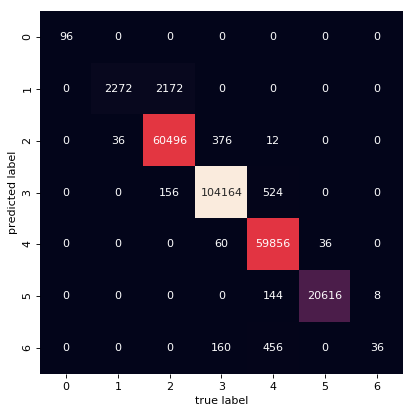

In [588]:
from sklearn.metrics import confusion_matrix
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

---

### Logistic Regression

In [39]:
%%time
lr = LogisticRegression(random_state = 0).fit(X_train, y_train)

Wall time: 2.18 s


In [569]:
y_pred = lr.predict(X_val)
print(classification_report(y_val, y_pred))
print("\nAccuracy Score is: " + str(accuracy_score(y_val, y_pred)))

             precision    recall  f1-score   support

        1RM       0.00      0.00      0.00        80
        2RM       0.00      0.00      0.00       580
        3RM       0.00      0.00      0.00     18880
        4RM       0.42      0.97      0.59     24752
        5RM       0.19      0.01      0.02     13644
        6EX       0.45      0.48      0.46      4200
        7MG       0.00      0.00      0.00        12

avg / total       0.24      0.42      0.27     62148


Accuracy Score is: 0.4221535689000451


C:\Users\longwind48\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



### K-Nearest Neighbors

In [570]:
%%time
knn = KNeighborsClassifier(n_neighbors=7, leaf_size=30, p=5, weights='distance').fit(X_train, y_train)

Wall time: 161 ms


In [571]:
knn_pred = knn.predict(X_val)

In [574]:
print(classification_report(y_val, knn_pred))
print("\nAccuracy Score is: " + str(accuracy_score(y_val, knn_pred)))

             precision    recall  f1-score   support

        1RM       0.67      0.50      0.57        80
        2RM       0.60      0.90      0.72       580
        3RM       0.91      0.95      0.93     18880
        4RM       0.89      0.91      0.90     24752
        5RM       0.90      0.82      0.85     13644
        6EX       0.88      0.81      0.84      4200
        7MG       0.00      0.00      0.00        12

avg / total       0.89      0.89      0.89     62148


Accuracy Score is: 0.8925146424663706


In [575]:
y_pred = knn.predict(X_test)

print("\nAccuracy Score is: " + str(accuracy_score(y_test, y_pred)))


Accuracy Score is: 0.7774758022219044
